# The Cox-Ingersoll-Ross (CIR) Model

The CIR model is a popular stochastic process used to model interest rate movements. It is defined by the equation:

$$ dr_t = a (b - r_t) dt + \sigma \sqrt{r_t} dW_t $$

Where:
- $r_t$ is the short-term interest rate at time $t$.
- $a$ is the speed of mean reversion.
- $b$ is the long-term mean of interest rates.
- $\sigma$ is the volatility of the interest rate.
- $dW_t$ is a Wiener process (random component).

### In a nutshell 
- **Mean Reversion**: The rate moves towards $b$ over time.
- **Non-Negativity**: Since the volatility term includes $\sqrt{r_t}$, interest rates stay positive.This is the main reason why this is more often used than the Vasicek model which ocassionally takes into account negative interest rates which in the real world have a very very very low probability of occuring 
- **Application**: Used in pricing bonds, options, and liability hedging strategies.

# Interactive Simulation of the CIR Model & Liability Hedging

In this notebook, we simulate the Cox-Ingersoll-Ross (CIR) model for interest rate dynamics and analyze its impact on liability hedging.

### Present Value of Liabilities and Funding Ratio 

The present value of a set of liabilities $L$ where each liability is $L_i$ is due at time $t_i$ is given by : 

$$ PV(L) = \sum_{i=1} B(t_i) L_i$$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t) is given by 

$$B(t)(1+r)^t = 1

In [2]:
import pandas as pd 
import numpy as np 
import edhec_riskKit as erk 
%load_ext autoreload 
%autoreload 2 

In [3]:
def discount(t, r):
    """
    compute the price of a pure discount bond that pays a dollar at time t, given interest rate r 
    """
    return (1+r)**(-t)

In [4]:
def pv(l, r):
    """
    Computes the present value of a sequecne of liabiklites 
    l is the indexed by the time , and the values are the amounts of each liability 
    returns the present value of the sequence
      """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

In [7]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
liabilities


3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [8]:
pv(liabilities, 0.03)

np.float64(6.233320315080045)

In [8]:
liabilities.sum()

np.float64(7.0)

In [9]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of some assets given liabilities and interest rate
    """
    return assets/pv(liabilities, r)


In [13]:
result = funding_ratio(5, pd.Series([7]), 0.03)
result

np.float64(0.7142857142857143)

# CIR Model to simulate changes in Interest rates and Liability Hedging 

The Cox Ingersoli Ross model is uded to model the dynamics of interest ratees, and is an extension of the popular Vasicek Model to prevent negative interest rates 
$$
dr_t = a(b - r_t) \, dt + \sigma \sqrt{r_t} \, dW_t
$$


In [14]:
def inst_to_ann(r):
    """
    Converts short rate to an annualized rate 
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert annulaized to a short rate 
    """
    return np.log1p(r)

def cir(n_years =10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Implements the CIR model for interest rates 
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year

    num_steps = int(n_years*steps_per_year)+1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for steps in range(1, num_steps):
        r_t = rates[steps-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)* shock[steps]
        rates[steps] =np.abs(r_t + d_r_t)

    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))


<Axes: >

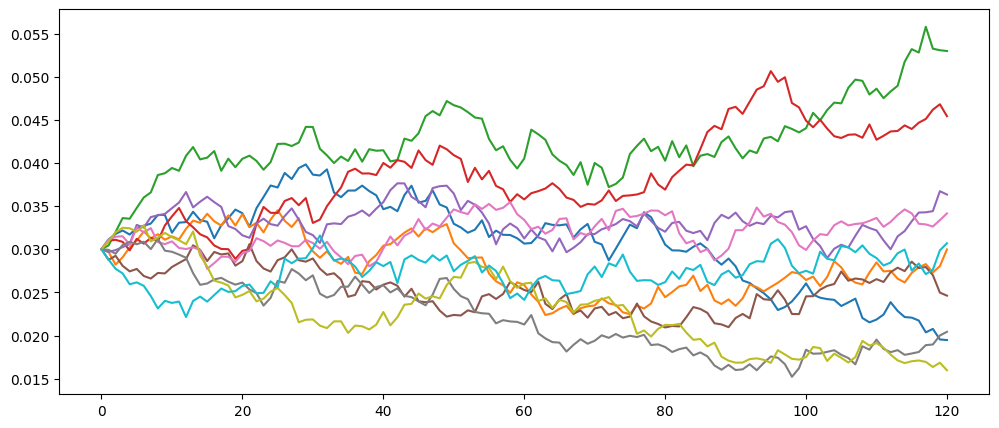

In [16]:
%matplotlib inline 
cir(n_scenarios=10, sigma=0.02).plot(figsize=(12,5), legend=False)

## Sensitivity Analysis

To understand how interest rate paths change with different parameters:
- Increase **mean reversion speed ($a$)** → Rates revert to $b$ faster.
- Increase **long-term mean ($b$)** → Higher overall interest rates.
- Increase **volatility ($\sigma$)** → More fluctuating rates.

We can run simulations with varying parameters and compare their impact on liability valuations.

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

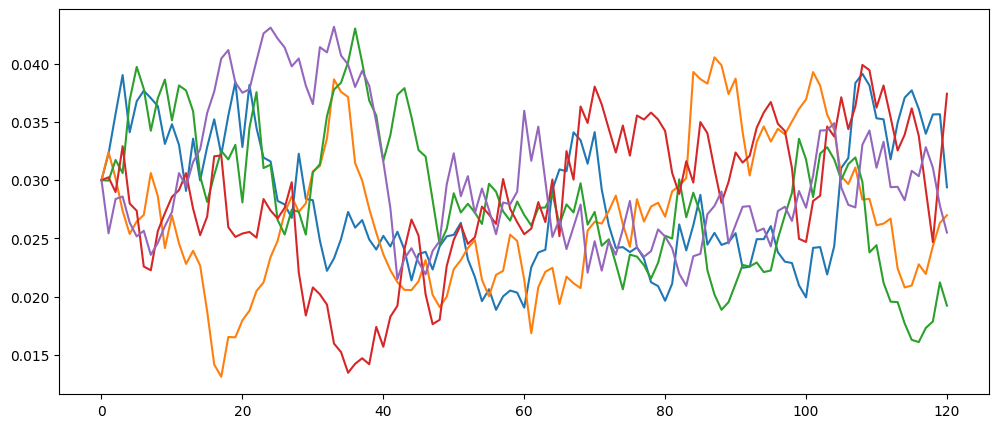

In [18]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12, 5))

import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir,
                               r_0=(0, 0.15, 0.01),
                               a=(0, 1, 0.1),
                               b=(0, 0.15, 0.01),
                               sigma=(0, 0.1, 0.01),
                               n_scenarios=(1, 100))

display(controls)

The model can also be used to generate the movement of bond prices for a zero-coupon bond that are implied by the generated interest rate, using the following equations:

$$
P(t, T) = A(t, T) e^{-B(t, T)r_t}
$$

where

$$
A(t, T) = \left( \frac{2h e^{(a + h)\tau / 2}}{2h + (a + h)(e^{h\tau} - 1)} \right)^{\frac{2ab}{\sigma^2}}
$$

and

$$
B(t, T) = \frac{2(e^{h\tau} - 1)}{2h + (a + h)(e^{h\tau} - 1)}
$$

and

$$
h = \sqrt{a^2 + 2\sigma^2}
$$

and

$$
\tau = T - t
$$

The computed interest rates are stored in a dataframe and transformed into annualized rates.


## Bond Price Calculation

The CIR model is extended to compute the price of a zero-coupon bond analytically. The bond price is given by:

$P(t, T) = A(t, T) e^{-B(t, T) r_t}$

where:
- $A(t, T)$ and $B(t, T)$ are derived based on CIR parameters.
- $r_t$ is the instantaneous short rate.

This method ensures we account for term structure and stochastic evolution of interest rates in bond pricing.

### Visualization of Simulated Prices

To visualize the results, we generate:
- **Multiple scenarios of zero-coupon bond prices** based on interest rate fluctuations.
- **Comparison of cash investments vs. zero-coupon bonds** to evaluate investment performance.
- **Histogram distributions** of terminal funding ratios using cash and bonds, showing their effectiveness in hedging liabilities.


In [19]:
def compounding_rate_inv(R, periods_per_year=None):
    '''
    Given a compounded rate, it returns the nominal rate from continuously compounding 
    r = log(1+R) if periods_per_year is None.
    If periods_per_year is not None, then returns the nominal rate from discrete 
    compounding r = N*((1+R)^1/N-1).
    '''
    if periods_per_year is None:
        return np.log(1+R)
    else:
        return periods_per_year * ( (1+R)**(1/periods_per_year) - 1 )
    
def compounding_rate(r, periods_per_year=None):
    '''
    Given a nominal rate r, it returns the continuously compounded rate R = e^r - 1 if periods_per_year is None.
    If periods_per_year is not None, then returns the discrete compounded rate R = (1+r/N)**N-1.
    '''
    if periods_per_year is None:
        return np.exp(r) - 1
    else:
        return (1 + r/periods_per_year)**periods_per_year - 1
    
def cirzc(n_years=10, n_scenarios=10, a=0.05, b=0.03, sigma=0.05, periods_per_year=12, r0=None):
    '''
    Evolution of (instantaneous) interest rates and corresponding zero-coupon bond using the CIR model:
        dr_t = a*(b-r_t) + sigma*sqrt(r_t)*xi,
    where xi are normal random variable N(0,1). 
    The analytical solution for the zero-coupon bond price is also computed.
    The method returns a dataframe of interest rate and zero-coupon bond prices
    '''
    if r0 is None:
        # Assign the long-term mean interest rate as initial rate
        r0 = b
        
    # Compute the price of a ZCB
    def zcbprice(ttm,r,h):
        A = ( ( 2*h*np.exp(0.5*(a+h)*ttm) ) / ( 2*h + (a+h)*(np.exp(h*ttm)-1) ) )**(2*a*b/(sigma**2))
        B = ( 2*(np.exp(h*ttm)-1) ) / ( 2*h + (a+h)*(np.exp(h*ttm)-1) ) 
        return A * np.exp(-B * r)
    
    dt = 1 / periods_per_year
    n_steps = int(n_years * periods_per_year) + 1
    
    # get the nominal (instantaneous) rate 
    r0 = compounding_rate_inv(r0)
    
    # the schock is sqrt(dt)*xi_t, with xi_t being standard normal r.v.
    shock = np.random.normal(loc=0, scale=(dt)**(0.5), size=(n_steps, n_scenarios))
    
    # Rates initialization
    rates = np.zeros_like(shock)
    rates[0] = r0 
    
    # Price initialization and parameters
    zcb_prices = np.zeros_like(shock)
    h = np.sqrt(a**2 + 2*sigma**2)
    zcb_prices[0] = zcbprice(n_years,r0,h)

    for step in range(1,n_steps):
        r_t = rates[step-1]
        r_t = np.maximum(r_t, 0)
        
        # Current (updated) interest rate: CIR equation
        rates[step] = r_t + a*(b - r_t) + sigma*np.sqrt(r_t)*shock[step]
        ttm= n_years - dt * step
        if ttm <= 0:
            zcb_prices[step] = 1
        else: 
            zcb_prices[step] = zcbprice(ttm, r_t, h)
        # Current (updated) ZCB price
        zcb_prices[step] = zcbprice(n_years - dt*step, r_t, h)       
 
    # the rates generated (according to the periods_per_year) are transformed back to annual rates
    rates = pd.DataFrame( compounding_rate(rates) )
    zcb_prices = pd.DataFrame( zcb_prices )

    return rates, zcb_prices

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

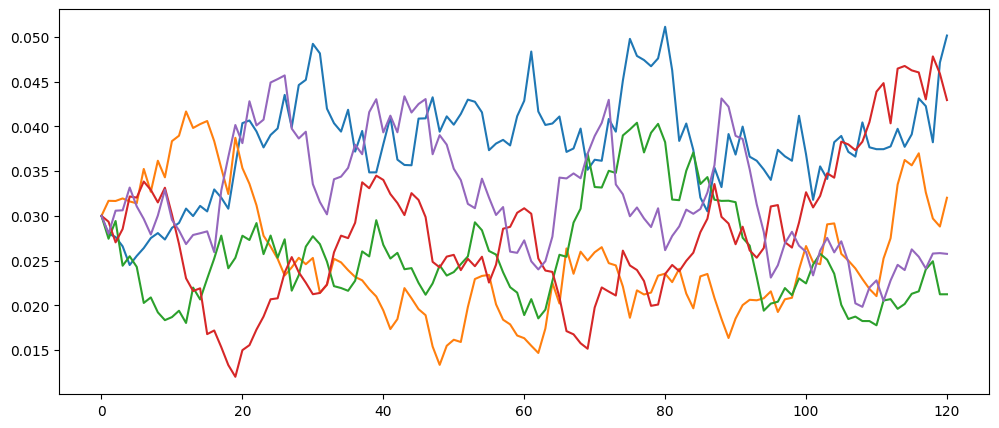

In [20]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12, 5))

controls = widgets.interactive(show_cir_prices,
                               r_0=(0, 0.15, 0.01),
                               a=(0, 1, 0.1),
                               b=(0, 0.15, 0.01),
                               sigma=(0, 0.1, 0.01),
                               n_scenarios=(1, 100))

display(controls)

In [21]:
a_0 = 0.75
rates, bond_prices = cirzc(n_years=10, b=0.03, n_scenarios=10)
liabilities = bond_prices
zc_bond_10 = pd.Series(data=[1], index=[10])
zc_0 = pv(zc_bond_10, r=0.03)
n_bonds = a_0/zc_0
av_zcbonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()


<Axes: >

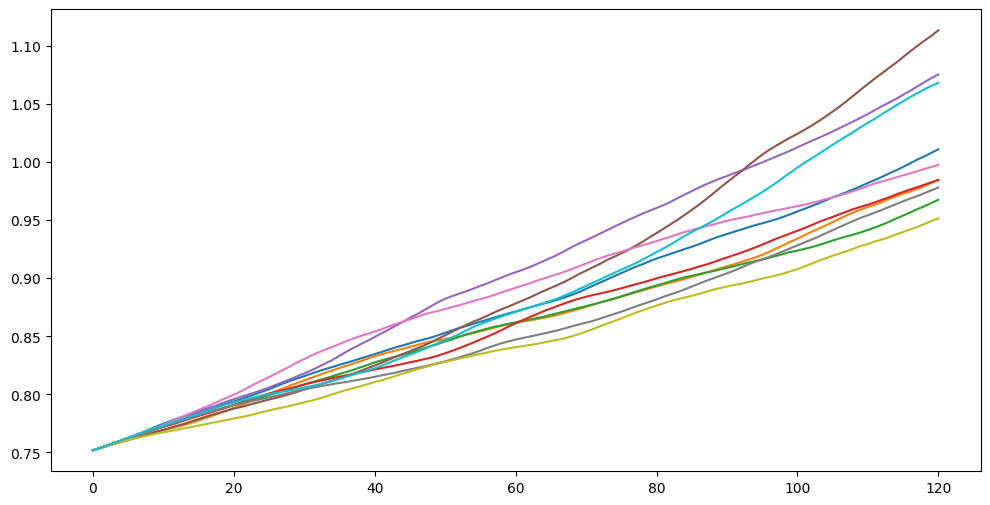

In [22]:
av_cash.plot(legend=False, figsize=(12,6))

<Axes: >

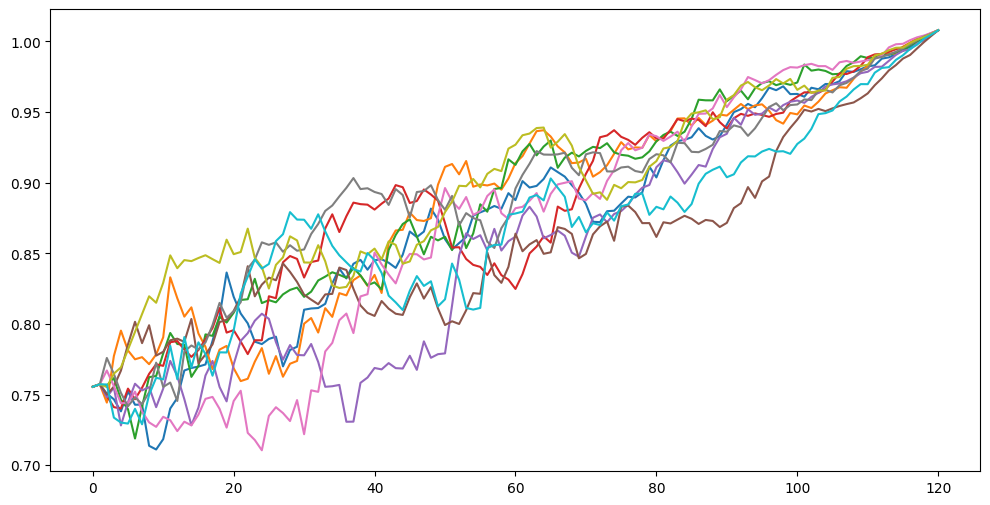

In [23]:
av_zcbonds.plot(legend=False, figsize=(12,6))

<Axes: title={'center': 'Returns of Funding ratio with cash (10 scenarios)'}>

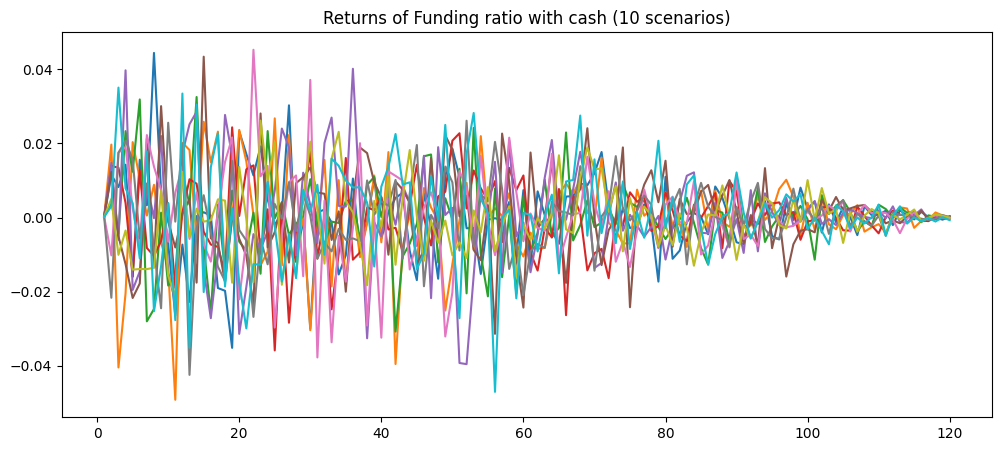

In [24]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding ratio with cash (10 scenarios)',legend=False, figsize=(12,5))

In [26]:
a_0 = 0.50
rates, bond_prices= cirzc(n_scenarios=10000, r0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = pv(zc_bond_10, 0.03)
n_bonds = a_0/zc_0
av_zcbonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

<Axes: >

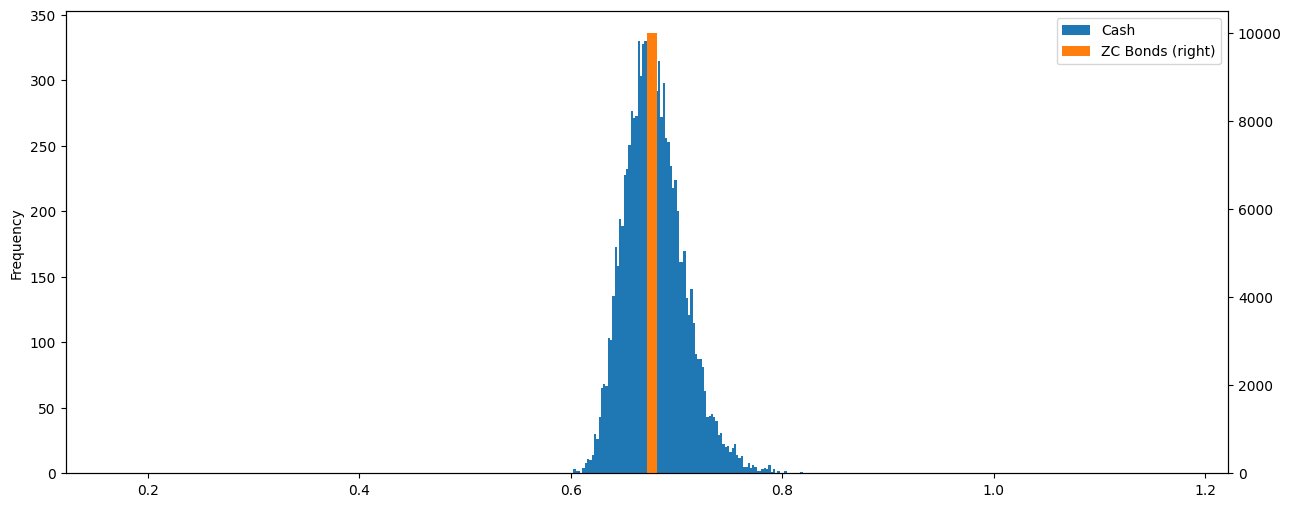

In [27]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zcbonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(15,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100, legend=True, secondary_y=True)

In [28]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Compute the ratios
tfr_cash = av_cash.iloc[-1] / liabilities.iloc[-1]
tfr_zc_bonds = av_zcbonds.iloc[-1] / liabilities.iloc[-1]

# Convert to DataFrame for easy plotting
df = pd.DataFrame({'Cash': tfr_cash, 'ZC Bonds': tfr_zc_bonds})

# Create an interactive slider for bins
bins_slider = widgets.IntSlider(value=50, min=10, max=200, step=10, description="Bins")

# Function to update the plot
def update_histogram(bins):
    plt.figure(figsize=(15, 6))
    
    plt.hist(df["Cash"], bins=bins, alpha=0.6, label="Cash")
    plt.hist(df["ZC Bonds"], bins=bins, alpha=0.6, label="ZC Bonds")

    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of TFR Cash vs. ZC Bonds")
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Display interactive widget
widgets.interactive(update_histogram, bins=bins_slider)


interactive(children=(IntSlider(value=50, description='Bins', max=200, min=10, step=10), Output()), _dom_class…